In [1]:
import os
import torch
import argparse
import warnings
import numpy as np
import anndata
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import os
import psutil
import time
import torch
import math

import numpy as np
import pandas as pd
import scanpy as sc
import scanpy.external as sce
import anndata
from pathlib import Path
from sklearn.metrics import pairwise_distances, calinski_harabasz_score
from scipy.sparse import issparse, isspmatrix_csr, csr_matrix, spmatrix
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.spatial import distance

from sklearn.linear_model import LinearRegression
from tqdm import tqdm
from typing import Union, Callable

from aug.utils_func import *
from aug.his_feat import image_feature, image_crop
from aug.adj import graph, combine_graph_dict
from aug.model import a_model, AdversarialNetwork
from aug.trainer import train
from aug.a import run
from aug.augment import augment_adata


D:\Edge\Anaconda3\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] 找不到指定的程序。
  warn(f"Failed to load image Python extension: {e}")


In [1]:
data_path = "./data/DLPFC" #### to your path
data_name = '151673' #### project name
save_path = "/Results" #### save path

In [4]:
n_domains = 7 ###### the number of spatial domains.

In [5]:
dlfren = run(save_path = save_path, 
	platform = "Visium",
	pca_n_comps = 200,
	pre_epochs = 800, #### According to your own hardware, choose the number of training
	epochs = 1000, #### According to your own hardware, choose the number of training
	Conv_type="GCNConv", #### you can choose GNN types. 
	)

In [6]:
adata = dlfren._get_adata(data_path, data_name)

D:\Edge\Anaconda3\lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
Tiling image: 100%|███████████████████████████████████████████████████████████████████████████████ [ time left: 00:00 ]
D:\Edge\Anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Edge\Anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Extract image feature: 100%|█████████████████████████████████████

In [9]:
adata = dlfren._get_augment(adata, adjacent_weight = 0.3, neighbour_k = 4,)

Physical distance calculting Done!
The number of nearest tie neighbors in physical distance is: 31.45452047265732
Gene correlation calculting Done!
Morphological similarity calculting Done!
The weight result of image feature is added to adata.obsm['weights_matrix_all'] !


Find adjacent spots of each spot: 100%|███████████████████████████████████████████████████████████ [ time left: 00:00 ]


Step 1: Augment gene representation is Done!


In [10]:
adata.shape

(3639, 33538)

In [11]:
adata_raw=adata

In [12]:
adata_h5=adata

In [13]:
from src.graph_func import graph_construction
from src.utils_func import mk_dir, adata_preprocess, load_visium_sge
from src.VGAE_train import VGAE_Train

In [14]:
warnings.filterwarnings('ignore')
torch.cuda.cudnn_enabled = False
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('===== Using device: ' + device)

===== Using device: cpu


In [15]:
################ Parameter setting
parser = argparse.ArgumentParser()
parser.add_argument('--k', type=int, default=10, help='parameter k in spatial graph')
parser.add_argument('--knn_distanceType', type=str, default='euclidean',
                    help='graph distance type: euclidean/cosine/correlation')
parser.add_argument('--epochs', type=int, default=200, help='Number of epochs to train.')
parser.add_argument('--cell_feat_dim', type=int, default=200, help='Dim of PCA')
parser.add_argument('--feat_hidden1', type=int, default=100, help='Dim of DNN hidden 1-layer.')
parser.add_argument('--feat_hidden2', type=int, default=20, help='Dim of DNN hidden 2-layer.')
parser.add_argument('--gcn_hidden1', type=int, default=32, help='Dim of GCN hidden 1-layer.')
parser.add_argument('--gcn_hidden2', type=int, default=10, help='Dim of GCN hidden 2-layer.')
parser.add_argument('--p_drop', type=float, default=0.2, help='Dropout rate.')
parser.add_argument('--using_dec', type=bool, default=True, help='Using DEC loss.')
parser.add_argument('--using_mask', type=bool, default=False, help='Using mask for multi-dataset.')
parser.add_argument('--feat_w', type=float, default=10, help='Weight of DNN loss.')
parser.add_argument('--gcn_w', type=float, default=0.1, help='Weight of GCN loss.')
parser.add_argument('--dec_kl_w', type=float, default=10, help='Weight of DEC loss.')
parser.add_argument('--gcn_lr', type=float, default=0.01, help='Initial GNN learning rate.')
parser.add_argument('--gcn_decay', type=float, default=0.01, help='Initial decay rate.')
parser.add_argument('--dec_cluster_n', type=int, default=10, help='DEC cluster number.')
parser.add_argument('--dec_interval', type=int, default=20, help='DEC interval nnumber.')
parser.add_argument('--dec_tol', type=float, default=0.00, help='DEC tol.')
# ______________ Eval clustering Setting _________
parser.add_argument('--eval_resolution', type=int, default=1, help='Eval cluster number.')
parser.add_argument('--eval_graph_n', type=int, default=20, help='Eval graph kN tol.') 

#params = parser.parse_args()
params = parser.parse_args(args=[]) 
 
params.device = device

In [16]:
adata_h5.var_names_make_unique()
adata_X = adata_preprocess(adata_h5, min_cells=5, pca_n_comps=params.cell_feat_dim)

===== Preprocessing Data 


In [18]:
graph_dict = graph_construction(adata_h5.obsm['spatial'], adata_h5.shape[0], params)
params.cell_num = adata_h5.shape[0]
print('==== Graph Construction Finished')

==== Graph Construction Finished


In [19]:
# ################## Model training
vgae_net = VGAE_Train(adata_X, graph_dict, params)
if params.using_dec:
    vgae_net.train_with_dec()
else:
    vgae_net.train_without_dec()
vgae_feat, _, feat_x, gnn_z = vgae_net.process()

GNN model train without DEC:  |################################| 200 / 200 | Left time: 0.02 mins| Loss: 144.4267
Training Graph Net with DEC loss:  |################################| 200 / 200 | Loss: 142.9787


In [20]:
gnn_z.shape

(3639, 10)

In [22]:
adata.shape

(3639, 18011)

In [23]:
import json
import functools
import operator
import collections
import jgraph
import numpy as np
import scipy.sparse
import tqdm

In [24]:
class dotdict(dict):
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__


def in_ipynb():  # pragma: no cover
    try:
        # noinspection PyUnresolvedReferences
        shell = get_ipython().__class__.__name__
        if shell == "ZMQInteractiveShell":
            return True   # Jupyter notebook or qtconsole
        elif shell == "TerminalInteractiveShell":
            return False  # Terminal running IPython
        else:
            return False  # Other type (?)
    except NameError:
        return False      # Probably standard Python interpreter


def smart_tqdm():  # pragma: no cover
    if in_ipynb():
        return tqdm.tqdm_notebook
    return tqdm.tqdm


def with_self_graph(fn):
    @functools.wraps(fn)
    def wrapped(self, *args, **kwargs):
        with self.graph.as_default():
            return fn(self, *args, **kwargs)
    return wrapped


# Wraps a batch function into minibatch version
def minibatch(batch_size, desc, use_last=False, progress_bar=True):
    def minibatch_wrapper(func):
        @functools.wraps(func)
        def wrapped_func(*args, **kwargs):
            total_size = args[0].shape[0]
            if use_last:
                n_batch = np.ceil(
                    total_size / float(batch_size)
                ).astype(np.int)
            else:
                n_batch = max(1, np.floor(
                    total_size / float(batch_size)
                ).astype(np.int))
            for batch_idx in smart_tqdm()(
                range(n_batch), desc=desc, unit="batches",
                leave=False, disable=not progress_bar
            ):
                start = batch_idx * batch_size
                end = min((batch_idx + 1) * batch_size, total_size)
                this_args = (item[start:end] for item in args)
                func(*this_args, **kwargs)
        return wrapped_func
    return minibatch_wrapper


# Avoid sklearn warning
def encode_integer(label, sort=False):
    label = np.array(label).ravel()
    classes = np.unique(label)
    if sort:
        classes.sort()
    mapping = {v: i for i, v in enumerate(classes)}
    return np.array([mapping[v] for v in label]), classes


# Avoid sklearn warning
def encode_onehot(label, sort=False, ignore=None):
    i, c = encode_integer(label, sort)
    onehot = scipy.sparse.csc_matrix((
        np.ones_like(i, dtype=np.int32), (np.arange(i.size), i)
    ))
    if ignore is None:
        ignore = []
    return onehot[:, ~np.in1d(c, ignore)].tocsr()


class CellTypeDAG(object):

    def __init__(self, graph=None, vdict=None):
        self.graph = jgraph.Graph(directed=True) if graph is None else graph
        self.vdict = {} if vdict is None else vdict

    @classmethod
    def load(cls, file):
        if file.endswith(".json"):
            return cls.load_json(file)
        elif file.endswith(".obo"):
            return cls.load_obo(file)
        else:
            raise ValueError("Unexpected file format!")

    @classmethod
    def load_json(cls, file):
        with open(file, "r") as f:
            d = json.load(f)
        dag = cls()
        dag._build_tree(d)
        return dag

    @classmethod
    def load_obo(cls, file):  # Only building on "is_a" relation between CL terms
        import pronto
        ont = pronto.Ontology(file)
        graph, vdict = jgraph.Graph(directed=True), {}
        for item in ont:
            if not item.id.startswith("CL"):
                continue
            if "is_obsolete" in item.other and item.other["is_obsolete"][0] == "true":
                continue
            graph.add_vertex(
                name=item.id, cell_ontology_class=item.name,
                desc=str(item.desc), synonyms=[(
                    "%s (%s)" % (syn.desc, syn.scope)
                 ) for syn in item.synonyms]
            )
            assert item.id not in vdict
            vdict[item.id] = item.id
            assert item.name not in vdict
            vdict[item.name] = item.id
            for synonym in item.synonyms:
                if synonym.scope == "EXACT" and synonym.desc != item.name:
                    vdict[synonym.desc] = item.id
        for source in graph.vs:
            for relation in ont[source["name"]].relations:
                if relation.obo_name != "is_a":
                    continue
                for target in ont[source["name"]].relations[relation]:
                    if not target.id.startswith("CL"):
                        continue
                    graph.add_edge(
                        source["name"],
                        graph.vs.find(name=target.id.split()[0])["name"]
                    )
                    # Split because there are many "{is_infered...}" suffix,
                    # falsely joined to the actual id when pronto parses the
                    # obo file
        return cls(graph, vdict)

    def _build_tree(self, d, parent=None):  # For json loading
        self.graph.add_vertex(name=d["name"])
        v = self.graph.vs.find(d["name"])
        if parent is not None:
            self.graph.add_edge(v, parent)
        self.vdict[d["name"]] = d["name"]
        if "alias" in d:
            for alias in d["alias"]:
                self.vdict[alias] = d["name"]
        if "children" in d:
            for subd in d["children"]:
                self._build_tree(subd, v)

    def get_vertex(self, name):
        return self.graph.vs.find(self.vdict[name])

    def is_related(self, name1, name2):
        return self.is_descendant_of(name1, name2) \
            or self.is_ancestor_of(name1, name2)

    def is_descendant_of(self, name1, name2):
        if name1 not in self.vdict or name2 not in self.vdict:
            return False
        shortest_path = self.graph.shortest_paths(
            self.get_vertex(name1), self.get_vertex(name2)
        )[0][0]
        return np.isfinite(shortest_path)

    def is_ancestor_of(self, name1, name2):
        if name1 not in self.vdict or name2 not in self.vdict:
            return False
        shortest_path = self.graph.shortest_paths(
            self.get_vertex(name2), self.get_vertex(name1)
        )[0][0]
        return np.isfinite(shortest_path)

    def conditional_prob(self, name1, name2):  # p(name1|name2)
        if name1 not in self.vdict or name2 not in self.vdict:
            return 0
        self.graph.vs["prob"] = 0
        v2_parents = list(self.graph.bfsiter(
            self.get_vertex(name2), mode=jgraph.OUT))
        v1_parents = list(self.graph.bfsiter(
            self.get_vertex(name1), mode=jgraph.OUT))
        for v in v2_parents:
            v["prob"] = 1
        while True:
            changed = False
            for v1_parent in v1_parents[::-1]:  # Reverse may be more efficient
                if v1_parent["prob"] != 0:
                    continue
                v1_parent["prob"] = np.prod([
                    v["prob"] / v.degree(mode=jgraph.IN)
                    for v in v1_parent.neighbors(mode=jgraph.OUT)
                ])
                if v1_parent["prob"] != 0:
                    changed = True
            if not changed:
                break
        return self.get_vertex(name1)["prob"]

    def similarity(self, name1, name2, method="probability"):
        if method == "probability":
            return (
                self.conditional_prob(name1, name2) +
                self.conditional_prob(name2, name1)
            ) / 2
        # if method == "distance":
        #     return self.distance_ratio(name1, name2)
        raise ValueError("Invalid method!")  # pragma: no cover

    def count_reset(self):
        self.graph.vs["raw_count"] = 0
        self.graph.vs["prop_count"] = 0  # count propagated from children
        self.graph.vs["count"] = 0

    def count_set(self, name, count):
        self.get_vertex(name)["raw_count"] = count

    def count_update(self):
        origins = [v for v in self.graph.vs.select(raw_count_gt=0)]
        for origin in origins:
            for v in self.graph.bfsiter(origin, mode=jgraph.OUT):
                if v != origin:  # bfsiter includes the vertex self
                    v["prop_count"] += origin["raw_count"]
        self.graph.vs["count"] = list(map(
            operator.add, self.graph.vs["raw_count"],
            self.graph.vs["prop_count"]
        ))

    def best_leaves(self, thresh, retrieve="name"):
        subgraph = self.graph.subgraph(self.graph.vs.select(count_ge=thresh))
        leaves, max_count = [], 0
        for leaf in subgraph.vs.select(lambda v: v.indegree() == 0):
            if leaf["count"] > max_count:
                max_count = leaf["count"]
                leaves = [leaf[retrieve]]
            elif leaf["count"] == max_count:
                leaves.append(leaf[retrieve])
        return leaves


class DataDict(collections.OrderedDict):

    def shuffle(self, random_state=np.random):
        shuffled = DataDict()
        shuffle_idx = None
        for item in self:
            shuffle_idx = random_state.permutation(self[item].shape[0]) \
                if shuffle_idx is None else shuffle_idx
            shuffled[item] = self[item][shuffle_idx]
        return shuffled

    @property
    def size(self):
        data_size = set([item.shape[0] for item in self.values()])
        assert len(data_size) == 1
        return data_size.pop()

    @property
    def shape(self):  # Compatibility with numpy arrays
        return [self.size]

    def __getitem__(self, fetch):
        if isinstance(fetch, (slice, np.ndarray)):
            return DataDict([
                (item, self[item][fetch]) for item in self
            ])
        return super(DataDict, self).__getitem__(fetch)


def densify(arr):
    if scipy.sparse.issparse(arr):
        return arr.toarray()
    return arr


def empty_safe(fn, dtype):
    def _fn(x):
        if x.size:
            return fn(x)
        return x.astype(dtype)
    return _fn


decode = empty_safe(np.vectorize(lambda _x: _x.decode("utf-8")), str)
encode = empty_safe(np.vectorize(lambda _x: str(_x).encode("utf-8")), "S")
upper = empty_safe(np.vectorize(lambda x: str(x).upper()), str)
lower = empty_safe(np.vectorize(lambda x: str(x).lower()), str)
tostr = empty_safe(np.vectorize(str), str)

In [25]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
#import utils as utils
import h5py
import scipy as sp
import numpy as np
import scanpy as sc
import pandas as pd
import os

In [26]:
def read_clean(data):
    assert isinstance(data, np.ndarray)
    if data.dtype.type is np.bytes_:
        data = decode(data)
    if data.size == 1:
        data = data.flat[0]
    return data


def dict_from_group(group):
    assert isinstance(group, h5py.Group)
    d = dotdict()
    for key in group:
        if isinstance(group[key], h5py.Group):
            value = dict_from_group(group[key])
        else:
            value = read_clean(group[key][...])
        d[key] = value
    return d


def read_data(filename, sparsify = False, skip_exprs = False):
    with h5py.File(filename, "r") as f:
        obs = pd.DataFrame(dict_from_group(f["obs"]), index = decode(f["obs_names"][...]))
        var = pd.DataFrame(dict_from_group(f["var"]), index = decode(f["var_names"][...]))
        uns = dict_from_group(f["uns"])
        if not skip_exprs:
            exprs_handle = f["exprs"]
            if isinstance(exprs_handle, h5py.Group):
                mat = sp.sparse.csr_matrix((exprs_handle["data"][...], exprs_handle["indices"][...],
                                               exprs_handle["indptr"][...]), shape = exprs_handle["shape"][...])
            else:
                mat = exprs_handle[...].astype(np.float32)
                if sparsify:
                    mat = sp.sparse.csr_matrix(mat)
        else:
            mat = sp.sparse.csr_matrix((obs.shape[0], var.shape[0]))
    return mat, obs, var, uns


def prepro(filename):
    data_path = filename
    mat, obs, var, uns = read_data(data_path, sparsify=False, skip_exprs=False)
    if isinstance(mat, np.ndarray):
        X = np.array(mat)
    else:
        X = np.array(mat.toarray())
    cell_name = np.array(obs["cell_type1"])
    cell_type, cell_label = np.unique(cell_name, return_inverse=True)
    return X, cell_label

def normalize(adata, copy=True, highly_genes = None, filter_min_counts=True, size_factors=True, normalize_input=True, logtrans_input=True):
    if isinstance(adata, sc.AnnData):
        if copy:
            adata = adata.copy()
    elif isinstance(adata, str):
        adata = sc.read(adata)
    else:
        raise NotImplementedError
    norm_error = 'Make sure that the dataset (adata.X) contains unnormalized count data.'
    assert 'n_count' not in adata.obs, norm_error
    if adata.X.size < 50e6: # check if adata.X is integer only if array is small
        if sp.sparse.issparse(adata.X):
            assert (adata.X.astype(int) != adata.X).nnz == 0, norm_error
        else:
            assert np.all(adata.X.astype(int) == adata.X), norm_error

    if filter_min_counts:
        sc.pp.filter_genes(adata, min_counts=1)
        sc.pp.filter_cells(adata, min_counts=1)
    if size_factors or normalize_input or logtrans_input:
        adata.raw = adata.copy()
    else:
        adata.raw = adata
    if size_factors:
        sc.pp.normalize_per_cell(adata)
        adata.obs['size_factors'] = adata.obs.n_counts / np.median(adata.obs.n_counts)
    else:
        adata.obs['size_factors'] = 1.0
    if logtrans_input:
        sc.pp.log1p(adata)
    if highly_genes != None:
        sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5, n_top_genes = highly_genes, subset=True)
    if normalize_input:
        sc.pp.scale(adata)
    return adata

In [27]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import tensorflow.keras.backend as K
import numpy as np

MeanAct = lambda x: tf.clip_by_value(K.exp(x), 1e-5, 1e6)
DispAct = lambda x: tf.clip_by_value(tf.nn.softplus(x), 1e-4, 1e4)

def _nan2zero(x):
    return tf.where(tf.is_nan(x), tf.zeros_like(x), x)

def _nan2inf(x):
    return tf.where(tf.is_nan(x), tf.zeros_like(x)+np.inf, x)

def _nelem(x):
    nelem = tf.reduce_sum(tf.cast(~tf.is_nan(x), tf.float32))
    return tf.cast(tf.where(tf.equal(nelem, 0.), 1., nelem), x.dtype)

def _reduce_mean(x):
    nelem = _nelem(x)
    x = _nan2zero(x)
    return tf.divide(tf.reduce_sum(x), nelem)

def NB(theta, y_true, y_pred, mask = False, debug = False, mean = False):
    eps = 1e-10
    scale_factor = 1.0
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32) * scale_factor
    if mask:
        nelem = _nelem(y_true)
        y_true = _nan2zero(y_true)
    theta = tf.minimum(theta, 1e6)
    t1 = tf.lgamma(theta + eps) + tf.lgamma(y_true + 1.0) - tf.lgamma(y_true + theta + eps)
    t2 = (theta + y_true) * tf.log(1.0 + (y_pred / (theta + eps))) + (y_true * (tf.log(theta + eps) - tf.log(y_pred + eps)))
    if debug:
        assert_ops = [tf.verify_tensor_all_finite(y_pred, 'y_pred has inf/nans'),
                      tf.verify_tensor_all_finite(t1, 't1 has inf/nans'),
                      tf.verify_tensor_all_finite(t2, 't2 has inf/nans')]
        with tf.control_dependencies(assert_ops):
            final = t1 + t2
    else:
        final = t1 + t2
    final = _nan2inf(final)
    if mean:
        if mask:
            final = tf.divide(tf.reduce_sum(final), nelem)
        else:
            final = tf.reduce_mean(final)
    return final

def ZINB(pi, theta, y_true, y_pred, ridge_lambda, mean = True, mask = False, debug = False):
    eps = 1e-10
    scale_factor = 1.0
    nb_case = NB(theta, y_true, y_pred, mean=False, debug=debug) - tf.log(1.0 - pi + eps)
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32) * scale_factor
    theta = tf.minimum(theta, 1e6)

    zero_nb = tf.pow(theta / (theta + y_pred + eps), theta)
    zero_case = -tf.log(pi + ((1.0 - pi) * zero_nb) + eps)
    result = tf.where(tf.less(y_true, 1e-8), zero_case, nb_case)
    ridge = ridge_lambda * tf.square(pi)
    result += ridge
    if mean:
        if mask:
            result = _reduce_mean(result)
        else:
            result = tf.reduce_mean(result)

    result = _nan2inf(result)
    return result

def cal_latent(hidden, alpha):
    sum_y = K.sum(K.square(hidden), axis=1)
    num = -2.0 * tf.matmul(hidden, tf.transpose(hidden)) + tf.reshape(sum_y, [-1, 1]) + sum_y
    num = num / alpha
    num = tf.pow(1.0 + num, -(alpha + 1.0) / 2.0)
    zerodiag_num = num - tf.linalg.diag(tf.linalg.diag_part(num))
    latent_p = K.transpose(K.transpose(zerodiag_num) / K.sum(zerodiag_num, axis=1))
    return num, latent_p

def target_dis(latent_p):
    latent_q = tf.transpose(tf.transpose(tf.pow(latent_p, 2)) / tf.reduce_sum(latent_p, axis = 1))
    return tf.transpose(tf.transpose(latent_q) / tf.reduce_sum(latent_q, axis = 1))

def cal_dist(hidden, clusters):
    dist1 = K.sum(K.square(K.expand_dims(hidden, axis=1) - clusters), axis=2)
    temp_dist1 = dist1 - tf.reshape(tf.reduce_min(dist1, axis=1), [-1, 1])
    q = K.exp(-temp_dist1)
    q = K.transpose(K.transpose(q) / K.sum(q, axis=1))
    q = K.pow(q, 2)
    q = K.transpose(K.transpose(q) / K.sum(q, axis=1))
    dist2 = dist1 * q
    return dist1, dist2

Instructions for updating:
non-resource variables are not supported in the long term


In [28]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from tensorflow.keras.layers import GaussianNoise, Dense, Activation
from sklearn.cluster import KMeans
#from loss import *
import os

In [29]:
class autoencoder(object):
    def __init__(self, dims, alpha, learning_rate, noise_sd, init='glorot_uniform', act='relu'):
        self.dims = dims
        self.alpha = alpha
        self.learning_rate = learning_rate
        self.noise_sd = noise_sd
        self.init = init
        self.act = act

        self.n_stacks = len(self.dims) - 1

        self.sf_layer = tf.placeholder(dtype=tf.float32, shape=(None, 1))
        self.x = tf.placeholder(dtype=tf.float32, shape=(None, self.dims[0]))
        self.x_count = tf.placeholder(dtype=tf.float32, shape=(None, self.dims[0]))

        self.h = self.x
        self.h = GaussianNoise(self.noise_sd, name='input_noise')(self.h)

        for i in range(self.n_stacks - 1):
            self.h = Dense(units=self.dims[i + 1], kernel_initializer=self.init, name='encoder_%d' % i)(self.h)
            self.h = GaussianNoise(self.noise_sd, name='noise_%d' % i)(self.h)  # add Gaussian noise
            self.h = Activation(self.act)(self.h)

        self.latent = Dense(units=self.dims[-1], kernel_initializer=self.init, name='encoder_hidden')(self.h)

        self.h1 = self.latent
        for i in range(self.n_stacks - 1, 0, -1):
            self.h1 = Dense(units=self.dims[i], activation=self.act, kernel_initializer=self.init, name='decoder_%d' % i)(self.h1)
        self.pi = Dense(units=self.dims[0], activation='sigmoid', kernel_initializer=self.init, name='pi')(self.h1)
        self.disp = Dense(units=self.dims[0], activation=DispAct, kernel_initializer=self.init, name='dispersion')(self.h1)
        self.mean = Dense(units=self.dims[0], activation=MeanAct, kernel_initializer=self.init, name='mean')(self.h1)
        self.output = self.mean * tf.matmul(self.sf_layer, tf.ones((1, self.mean.get_shape()[1]), dtype=tf.float32))
        self.likelihood_loss = ZINB(self.pi, self.disp, self.x_count, self.output, ridge_lambda=1.0)

        self.h2 = self.latent
        for i in range(self.n_stacks - 1, 0, -1):
            self.h2 = Dense(units=self.dims[i], activation=self.act, kernel_initializer=self.init,
                            name='decoder_recon_%d' % i)(self.h2)
        self.recon=Dense(units=self.dims[0], activation='relu', kernel_initializer=self.init,
                            name='decoder_recon_x')(self.h2)
        self.pretrain_loss=self.likelihood_loss+self.alpha*tf.keras.losses.MSE( self.mean, self.recon)
        self.optimizer = tf.train.AdamOptimizer(self.learning_rate)
        self.pretrain_op = self.optimizer.minimize(self.pretrain_loss)

    def pretrain(self, X, count_X, size_factor, batch_size, pretrain_epoch, gpu_option):
        print("begin the pretraining")
        init = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
        os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
        os.environ["CUDA_VISIBLE_DEVICES"] = gpu_option
        config_ = tf.ConfigProto()
        config_.gpu_options.allow_growth = True
        config_.allow_soft_placement = True
        self.sess = tf.Session(config=config_)
        self.sess.run(init)

        self.latent_repre = np.zeros((X.shape[0], self.dims[-1]))
        pre_index = 0
        for ite in range(pretrain_epoch):
            while True:
                if (pre_index + 1) * batch_size > X.shape[0]:
                    last_index = np.array(list(range(pre_index * batch_size, X.shape[0])) + list(
                        range((pre_index + 1) * batch_size - X.shape[0])))
                    _, likelihood_loss, latent = self.sess.run([self.pretrain_op, self.likelihood_loss, self.latent],
                        feed_dict={
                            self.sf_layer: size_factor[last_index],
                            self.x: X[last_index],
                            self.x_count: count_X[last_index]})
                    self.latent_repre[last_index] = latent
                    pre_index = 0
                    break
                else:
                    _, likelihood_loss, latent = self.sess.run(
                        [self.pretrain_op, self.likelihood_loss, self.latent],
                        feed_dict={
                            self.sf_layer: size_factor[(pre_index * batch_size):(
                                    (pre_index + 1) * batch_size)],
                            self.x: X[(pre_index * batch_size):(
                                    (pre_index + 1) * batch_size)],
                            self.x_count: count_X[(pre_index * batch_size):(
                                    (pre_index + 1) * batch_size)]})
                    self.latent_repre[(pre_index * batch_size):((pre_index + 1) * batch_size)] = latent
                    pre_index += 1

In [30]:
import tensorflow.compat.v1 as tf

tf.disable_v2_behavior()

#from preprocess import *
#from network import *
#from utils import *


def cluster_acc(y_true, y_pred):
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    from sklearn.utils.linear_assignment_ import linear_assignment
    ind = linear_assignment(w.max() - w)
    return sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

In [31]:
def train_DualSCDC(x_nomalized, count_X,  size_factor,y,  name, dims, alpha, learning_rate, noise_sd, batch_size, pretrain_epoch, gpu_option):
    import numpy as np
    #import tensorflow as tf
    import tensorflow.compat.v1 as tf
    
    ##args
    import argparse
    #random_seed_list = "1111, 2222, 3333, 4444, 5555, 6666, 7777, 8888, 9999, 10000"
    parser = argparse.ArgumentParser(description="train", formatter_class=argparse.ArgumentDefaultsHelpFormatter)
    parser.add_argument("--dataname", default="Adam", type=str)
    parser.add_argument("--highly_genes", default=2200, type=int)
    #parser.add_argument("--random_seed", default=random_seed_list)
    parser.add_argument("--dims", default="256,16")
    parser.add_argument("--alpha", default=0.00001, type=float)
    parser.add_argument("--learning_rate", default=0.0001, type=float)
    parser.add_argument("--batch_size", default=256, type=int)
    parser.add_argument("--pretrain_epoch", default=1000, type=int)
    parser.add_argument("--noise_sd", default=1.5, type=float)
    parser.add_argument("--gpu_option", default="2")
    args = parser.parse_args(args=[])
    
    from tensorflow.keras.layers import GaussianNoise, Dense, Activation
    ####autoencoder
    class autoencoder(object):
        def __init__(self, dims, alpha, learning_rate, noise_sd, init='glorot_uniform', act='relu'):
            self.dims = dims
            self.alpha = alpha
            self.learning_rate = learning_rate
            self.noise_sd = noise_sd
            self.init = init
            self.act = act
    
            self.n_stacks = len(self.dims) - 1
    
            tf.compat.v1.disable_eager_execution()
            self.sf_layer = tf.placeholder(dtype=tf.float32, shape=(None, 1))
            self.x = tf.placeholder(dtype=tf.float32, shape=(None, self.dims[0]))
            self.x_count = tf.placeholder(dtype=tf.float32, shape=(None, self.dims[0]))
    
            self.h = self.x
            self.h = GaussianNoise(self.noise_sd, name='input_noise')(self.h)
    
            for i in range(self.n_stacks - 1):
                self.h = Dense(units=self.dims[i + 1], kernel_initializer=self.init, name='encoder_%d' % i)(self.h)
                self.h = GaussianNoise(self.noise_sd, name='noise_%d' % i)(self.h)  # add Gaussian noise
                self.h = Activation(self.act)(self.h)
    
            self.latent = Dense(units=self.dims[-1], kernel_initializer=self.init, name='encoder_hidden')(self.h)
    
            self.h1 = self.latent
##############################################################################################################################################
            MeanAct = lambda x: tf.clip_by_value(K.exp(x), 1e-5, 1e6)
            DispAct = lambda x: tf.clip_by_value(tf.nn.softplus(x), 1e-4, 1e4)
            for i in range(self.n_stacks - 1, 0, -1):
                self.h1 = Dense(units=self.dims[i], activation=self.act, kernel_initializer=self.init, name='decoder_%d' % i)(self.h1)
            self.pi = Dense(units=self.dims[0], activation='sigmoid', kernel_initializer=self.init, name='pi')(self.h1)
            self.disp = Dense(units=self.dims[0], activation=DispAct, kernel_initializer=self.init, name='dispersion')(self.h1)
            #self.disp = Dense(units=self.dims[0], activation='relu', kernel_initializer=self.init, name='dispersion')(self.h1)
            self.mean = Dense(units=self.dims[0], activation=MeanAct, kernel_initializer=self.init, name='mean')(self.h1)
            #self.mean = Dense(units=self.dims[0], activation='tanh', kernel_initializer=self.init, name='mean')(self.h1)
            self.output = self.mean * tf.matmul(self.sf_layer, tf.ones((1, self.mean.get_shape()[1]), dtype=tf.float32))
            self.likelihood_loss = ZINB(self.pi, self.disp, self.x_count, self.output, ridge_lambda=1.0)
    
            self.h2 = self.latent
            for i in range(self.n_stacks - 1, 0, -1):
                self.h2 = Dense(units=self.dims[i], activation=self.act, kernel_initializer=self.init,
                                name='decoder_recon_%d' % i)(self.h2)
            self.recon=Dense(units=self.dims[0], activation='relu', kernel_initializer=self.init,
                                name='decoder_recon_x')(self.h2)
            self.pretrain_loss=self.likelihood_loss+self.alpha*tf.keras.losses.MSE( self.mean, self.recon)
            self.optimizer = tf.train.AdamOptimizer(self.learning_rate)
            self.pretrain_op = self.optimizer.minimize(self.pretrain_loss)

        def pretrain(self, X, count_X, size_factor, batch_size, pretrain_epoch, gpu_option):
            import os
            print("begin the pretraining")
            init = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
            os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
            os.environ["CUDA_VISIBLE_DEVICES"] = gpu_option
            config_ = tf.ConfigProto()
            config_.gpu_options.allow_growth = True
            config_.allow_soft_placement = True
            self.sess = tf.Session(config=config_)
            self.sess.run(init)
    
            self.latent_repre = np.zeros((X.shape[0], self.dims[-1]))
            pre_index = 0
            for ite in range(pretrain_epoch):
                while True:
                    if (pre_index + 1) * batch_size > X.shape[0]:
                        last_index = np.array(list(range(pre_index * batch_size, X.shape[0])) + list(
                            range((pre_index + 1) * batch_size - X.shape[0])))
                        _, likelihood_loss, latent = self.sess.run([self.pretrain_op, self.likelihood_loss, self.latent],
                            feed_dict={
                                self.sf_layer: size_factor[last_index],
                                self.x: X[last_index],
                                self.x_count: count_X[last_index]})
                        self.latent_repre[last_index] = latent
                        pre_index = 0
                        break
                    else:
                        _, likelihood_loss, latent = self.sess.run(
                            [self.pretrain_op, self.likelihood_loss, self.latent],
                            feed_dict={
                                self.sf_layer: size_factor[(pre_index * batch_size):(
                                        (pre_index + 1) * batch_size)],
                                self.x: X[(pre_index * batch_size):(
                                        (pre_index + 1) * batch_size)],
                                self.x_count: count_X[(pre_index * batch_size):(
                                        (pre_index + 1) * batch_size)]})
                        self.latent_repre[(pre_index * batch_size):((pre_index + 1) * batch_size)] = latent
                        pre_index += 1
    ######loss
    import tensorflow.compat.v1 as tf
    tf.disable_v2_behavior()
    import tensorflow.keras.backend as K
    import numpy as np
    
    MeanAct = lambda x: tf.clip_by_value(K.exp(x), 1e-5, 1e6)
    DispAct = lambda x: tf.clip_by_value(tf.nn.softplus(x), 1e-4, 1e4)
    
    def _nan2zero(x):
        return tf.where(tf.is_nan(x), tf.zeros_like(x), x)
    
    def _nan2inf(x):
        return tf.where(tf.is_nan(x), tf.zeros_like(x)+np.inf, x)
    
    def _nelem(x):
        nelem = tf.reduce_sum(tf.cast(~tf.is_nan(x), tf.float32))
        return tf.cast(tf.where(tf.equal(nelem, 0.), 1., nelem), x.dtype)
    
    def _reduce_mean(x):
        nelem = _nelem(x)
        x = _nan2zero(x)
        return tf.divide(tf.reduce_sum(x), nelem)
    
    def NB(theta, y_true, y_pred, mask = False, debug = False, mean = False):
        eps = 1e-10
        scale_factor = 1.0
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32) * scale_factor
        if mask:
            nelem = _nelem(y_true)
            y_true = _nan2zero(y_true)
        theta = tf.minimum(theta, 1e6)
        t1 = tf.lgamma(theta + eps) + tf.lgamma(y_true + 1.0) - tf.lgamma(y_true + theta + eps)
        t2 = (theta + y_true) * tf.log(1.0 + (y_pred / (theta + eps))) + (y_true * (tf.log(theta + eps) - tf.log(y_pred + eps)))
        if debug:
            assert_ops = [tf.verify_tensor_all_finite(y_pred, 'y_pred has inf/nans'),
                          tf.verify_tensor_all_finite(t1, 't1 has inf/nans'),
                          tf.verify_tensor_all_finite(t2, 't2 has inf/nans')]
            with tf.control_dependencies(assert_ops):
                final = t1 + t2
        else:
            final = t1 + t2
        final = _nan2inf(final)
        if mean:
            if mask:
                final = tf.divide(tf.reduce_sum(final), nelem)
            else:
                final = tf.reduce_mean(final)
        return final
    
    def ZINB(pi, theta, y_true, y_pred, ridge_lambda, mean = True, mask = False, debug = False):
        eps = 1e-10
        scale_factor = 1.0
        nb_case = NB(theta, y_true, y_pred, mean=False, debug=debug) - tf.log(1.0 - pi + eps)
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32) * scale_factor
        theta = tf.minimum(theta, 1e6)
    
        zero_nb = tf.pow(theta / (theta + y_pred + eps), theta)
        zero_case = -tf.log(pi + ((1.0 - pi) * zero_nb) + eps)
        result = tf.where(tf.less(y_true, 1e-8), zero_case, nb_case)
        ridge = ridge_lambda * tf.square(pi)
        result += ridge
        if mean:
            if mask:
                result = _reduce_mean(result)
            else:
                result = tf.reduce_mean(result)
    
        result = _nan2inf(result)
        return result
    
    def cal_latent(hidden, alpha):
        sum_y = K.sum(K.square(hidden), axis=1)
        num = -2.0 * tf.matmul(hidden, tf.transpose(hidden)) + tf.reshape(sum_y, [-1, 1]) + sum_y
        num = num / alpha
        num = tf.pow(1.0 + num, -(alpha + 1.0) / 2.0)
        zerodiag_num = num - tf.linalg.diag(tf.linalg.diag_part(num))
        latent_p = K.transpose(K.transpose(zerodiag_num) / K.sum(zerodiag_num, axis=1))
        return num, latent_p
    
    def target_dis(latent_p):
        latent_q = tf.transpose(tf.transpose(tf.pow(latent_p, 2)) / tf.reduce_sum(latent_p, axis = 1))
        return tf.transpose(tf.transpose(latent_q) / tf.reduce_sum(latent_q, axis = 1))
    
    def cal_dist(hidden, clusters):
        dist1 = K.sum(K.square(K.expand_dims(hidden, axis=1) - clusters), axis=2)
        temp_dist1 = dist1 - tf.reshape(tf.reduce_min(dist1, axis=1), [-1, 1])
        q = K.exp(-temp_dist1)
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1))
        q = K.pow(q, 2)
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1))
        dist2 = dist1 * q
        return dist1, dist2
    
    
    
    
    
    
    if x_nomalized.shape[0] > 1e4:
        batch_size = 2*batch_size
    #np.random.seed(seed)
    tf.compat.v1.reset_default_graph()
    temp_dims = args.dims.split(',')
    temp = [x_nomalized.shape[1]]
    temp.extend(temp_dims)
    dimsNew = list(map(int,temp))
    ae = autoencoder(dimsNew, alpha, learning_rate, noise_sd)
    ae.pretrain(x_nomalized, count_X, size_factor, batch_size, pretrain_epoch, gpu_option)
    pre = np.array(ae.latent_repre)
    #import scipy.io as scio
    #scio.savemat(
    #    '../mdata/{}_seed_{}.mat'.format(name, seed),
    #    {'data': pre, 'label': y})
    del ae
    return pre

In [32]:
from pathos.multiprocessing import ProcessingPool as Pool
import os
import argparse


parser = argparse.ArgumentParser(description="train", formatter_class=argparse.ArgumentDefaultsHelpFormatter)
parser.add_argument("--dataname", default="151673", type=str)
parser.add_argument("--highly_genes", default=2200, type=int)
#parser.add_argument("--random_seed", default=random_seed_list)
parser.add_argument("--dims", default="256,16")
parser.add_argument("--alpha", default=0.00001, type=float)
parser.add_argument("--learning_rate", default=0.0001, type=float)
parser.add_argument("--batch_size", default=256, type=int)
parser.add_argument("--pretrain_epoch", default=1000, type=int)
parser.add_argument("--noise_sd", default=1.5, type=float)
parser.add_argument("--gpu_option", default="2")
args = parser.parse_args(args=[])
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
gpu_id = '0'
os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu_id)
os.system('echo $CUDA_VISIBLE_DEVICES')
import pandas as pd
import numpy as np 
name = args.dataname
dims = args.dims
alpha = args.alpha
learning_rate = args.learning_rate
noise_sd = args.noise_sd
batch_size = args.batch_size
pretain_epoch =  args.pretrain_epoch
gpu_option = args.gpu_option


filepath = './DLPFC/' + name
#if os.path.exists(filepath + '/filtered_feature_bc_matrix.h5')

In [33]:
###.h5文件表示基因的表达信息，spatial为空间位置信息。加载空间转录组文件
#def load_ST_file(file_fold, count_file='filtered_feature_bc_matrix.h5', load_images=True, file_Adj=None):
#    adata_h5 = sc.read_visium(file_fold, load_images=load_images, count_file=count_file)##读取文件
#    adata_h5.var_names_make_unique()
#
#    print('adata: (' + str(adata_h5.shape[0]) + ', ' + str(adata_h5.shape[1]) + ')')
#    return adata_h5
#adata=load_ST_file("C:/Users/申展/study of ST/1/DLPFC/151673", count_file='filtered_feature_bc_matrix.h5', load_images=True, file_Adj=None)

In [34]:
adata.shape

(3639, 18011)

In [35]:
data=adata.X
data = data.todense()
x_raw=data

In [36]:
# add ground_truth
df_meta = pd.read_csv('./data/DLPFC/151673/metadata.tsv', sep='\t')
df_meta_layer = df_meta['layer_guess']
adata.obs['Group'] = df_meta_layer.values
y=adata.obs['Group']

In [37]:
x_raw = np.ceil(x_raw).astype(np.int_)
count_X = x_raw.copy()
adata = sc.AnnData(x_raw.copy())
adata.obs['Group'] = y
adata = normalize(adata, copy=True, highly_genes=args.highly_genes, size_factors=True, normalize_input=True,logtrans_input=True)
x_nomalized = adata.X.astype(np.float32)
x_normalized_DC = x_nomalized[1]
Y = np.array(adata.obs["Group"])
high_variable = np.array(adata.var.highly_variable.index, dtype=np.int_)
count_X = count_X[:, high_variable]
size_factor = np.array(adata.obs.size_factors).reshape(-1, 1).astype(np.float32)


x_train =x_nomalized.copy()
count_x_train = count_X.copy()
size_factor_train = size_factor.copy()
y_train = Y
namelist = name
dimslist = dims 
alphalist =alpha
learning_ratelist = learning_rate
noise_sdlist = noise_sd
batch_sizelist =batch_size
pretrain_epochlist = pretain_epoch
gpu_optionlist = gpu_option
latent=train_DualSCDC( x_train, count_x_train, size_factor_train, y_train,  namelist, dimslist, alphalist, learning_ratelist, noise_sdlist, batch_sizelist, pretrain_epochlist, gpu_optionlist)

begin the pretraining


In [38]:
latent1=np.array(latent)
def normalization(data):
    _range = np.max(abs(data))
    return data / _range
latent2=normalization(latent1)

In [39]:
latent3= torch.tensor(latent2)
#gcn_feat=torch.tensor(sedr_feat)
gcn_feat=torch.tensor(gnn_z)
feat=torch.cat([latent3,gcn_feat], 1)
feature=np.array(feat)

In [40]:
import os
import umap
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sknetwork.clustering import Louvain, KMeans
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import SpectralClustering

def get_umap(node_embs):
    reducer = umap.UMAP(n_neighbors=20, metric='cosine', random_state=42)
    return reducer.fit_transform(node_embs)

def proc_clustering(feature, params):
    latent_z_adj = kneighbors_graph(feature, params.eval_graph_n, mode='connectivity', include_self=True)
    if params.eval_cluster_type == 'Louvain':
        print('==== Clustering by Louvain')
        cluster_handle = Louvain()
        result = cluster_handle.fit_transform(latent_z_adj)
    elif params.eval_cluster_type == 'KMeans':
        print('==== Clustering by KMeans')
        cluster_handle = KMeans(n_clusters=params.eval_cluster_n)
        result = cluster_handle.fit_transform(latent_z_adj)
    else:
        print('==== Clustering by Spectral Clustering')
        cluster_handle = SpectralClustering(n_clusters=params.eval_cluster_n, affinity='precomputed',
                                            n_init=100, assign_labels='discretize', random_state=0)
        result = cluster_handle.fit_predict(latent_z_adj)
    return result

def eval_clustering(feat_dict, save_path, params, label=None):
    # clustering
    sed_labels = proc_clustering(feat_dict['sed_feat'], params)
    df_result = pd.DataFrame(sed_labels, columns=['sed_labels'])

    if feat_dict['deep_labels'] is not None:
        df_result['deep_labels'] = proc_clustering(feat_dict['deep_feat'], params)
    if label is not None:
        df_result['layer_guess'] = label
    if feat_dict['gnn_feat'] is not None:
        df_result['gnn_labels'] = proc_clustering(feat_dict['gnn_feat'], params)

    df_result.to_csv(os.path.join(save_path, params.eval_cluster_type + "_k_" +
                                  str(params.eval_cluster_n) + "_result.tsv"), sep='\t', index=False)

    return sed_labels

def plot_umap(node_feature, latent_z, save_path, params, label=None, colormap='tab20'):
    print('==== Computing UMAP by node_feature')
    umap_org = get_umap(node_feature)
    print('==== Computing UMAP by latent_z')
    umap_node = get_umap(latent_z)

    if label is None:
        label = proc_clustering(latent_z, params)

    fig, ax_list = plt.subplots(1, 2, figsize=(6, 3))
    sns.scatterplot(x=umap_org[:, 0], y=umap_org[:, 1], hue=label, palette=colormap, s=4, ax=ax_list[0])
    sns.scatterplot(x=umap_node[:, 0], y=umap_node[:, 1], hue=label, palette=colormap, s=4, ax=ax_list[1])

    for m_idx in range(len(ax_list)):
        plt.setp(ax_list[m_idx].spines.values(), color='black')
        ax_list[m_idx].spines['left'].set_linewidth(0.2)
        ax_list[m_idx].spines['top'].set_linewidth(0.2)
        ax_list[m_idx].spines['bottom'].set_linewidth(0.2)
        ax_list[m_idx].spines['right'].set_linewidth(0.2)
        ax_list[m_idx].get_xaxis().set_visible(False)
        ax_list[m_idx].get_yaxis().set_visible(False)

    ax_list[0].get_legend().remove()
    ax_list[0].set_title("DNN", position=(0.5, 0.9), fontdict={'fontsize': 8})
    ax_list[1].legend(handletextpad=0.3, fontsize=4, frameon=False, bbox_to_anchor=(1.04, 1))
    ax_list[1].set_title("DEC", position=(0.5, 0.9), fontdict={'fontsize': 8})
    plt.savefig(os.path.join(save_path, "result_plot.jpg"), dpi=200, bbox_inches='tight')
    
def res_search_fixed_clus(adata, fixed_clus_count, increment=0.02):
    '''
        arg1(adata)[AnnData matrix]
        arg2(fixed_clus_count)[int]
        
        return:
            resolution[int]
    '''
    for res in sorted(list(np.arange(0.2,2.5, increment)), reverse=True):
        sc.tl.leiden(adata, random_state=0, resolution=res)
        count_unique_leiden = len(pd.DataFrame(adata.obs['leiden']).leiden.unique())
        if count_unique_leiden == fixed_clus_count:
            break
    return res  

In [41]:
#feature=np.array(feat)
adata_a = anndata.AnnData(feature)
adata_a.uns['spatial'] = adata_h5.uns['spatial']
adata_a.obsm['spatial'] = adata_h5.obsm['spatial']

In [42]:
sc.pp.neighbors(adata_a, n_neighbors=params.eval_graph_n)
sc.tl.umap(adata_a)
n_clusters=7
eval_resolution = res_search_fixed_clus(adata_a, n_clusters)
sc.tl.leiden(adata_a, key_added="leiden", resolution=eval_resolution)

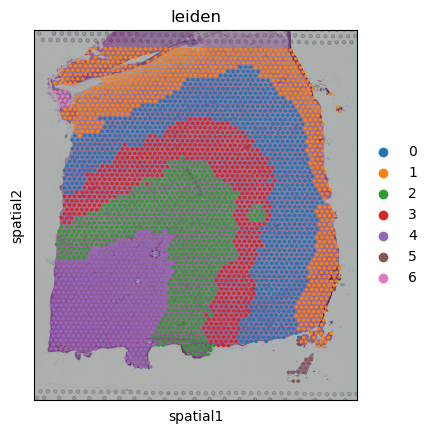

In [43]:
sc.pl.spatial(adata_a, img_key="hires", color=['leiden'])

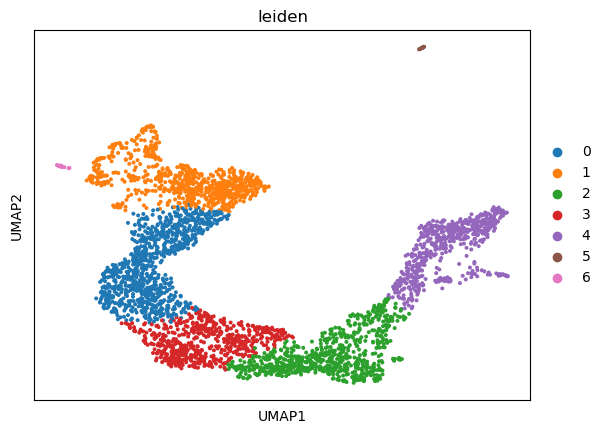

In [44]:
##可视化UMAP和tense的结果
sc.pl.umap(adata_a,color="leiden")

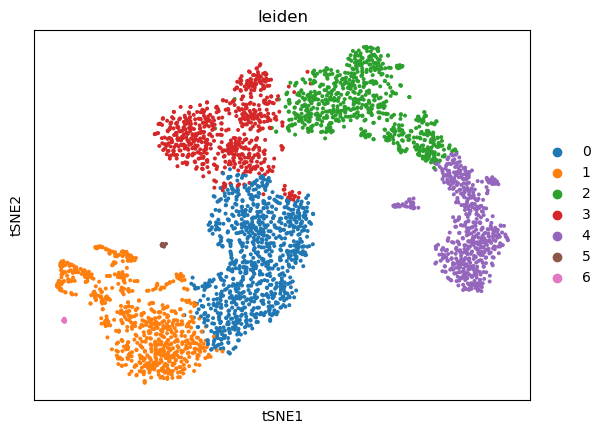

In [45]:
sc.tl.tsne(adata_a)
sc.pl.tsne(adata_a, color=['leiden'])

In [46]:
data_name='151673'
df_meta = pd.read_csv('./data/DLPFC/151673/metadata.tsv', sep='\t')
df_meta['a'] = adata_a.obs['leiden'].tolist()
#df_meta.to_csv(f'{params.save_path}/metadata.tsv', sep='\t', index=False)
# #################### evaluation
# ---------- Load manually annotation ---------------
df_meta = df_meta[~pd.isnull(df_meta['layer_guess'])]
from sklearn import metrics 
ARI = metrics.adjusted_rand_score(df_meta['layer_guess'], df_meta['a'])
print('===== Project: {} ARI score: {:.3f}'.format(data_name, ARI))

===== Project: 151673 ARI score: 0.616
